<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Проект выполнил Деревянов Сергей. Декабрь 2021 г.

### Проект: Прогнозирование стоимости автомобиля по характеристикам

### Основная задача: Предсказать стоимость автомобиля по его характеристикам.

Рамки проекта:
* Разрешено использовать внешние данные. (но их источник должен быть публичным и доступен всем участникам соревнования)
* Разрешено использовать любые ML алгоритмы и библиотеки. (кроме DL)
* Основная мертрика модели: MAPE (Mean Absolute Percentage Error).

# Содержание работы:
### 1. [Импорт библиотек](#introduction)
### 2. [Имортируем датасеты](#paragraph1)
### 3. [Предобработка данных](#paragraph2)
### 4. [EDA](#paragraph3)
### 5. [Feature engineering](#paragraph4)
### 6. [Lable encoding](#paragraph5)
### 7. [Подготовка данных для обучения](#paragraph6)
### 8. [Модель 1. "Наивная" модель](#paragraph7)
### 9. [Модель 2. CatBoost](#paragraph8)
### 10. [Модель 3. RandomForest](#paragraph9)
### 11. [Модель 4. ExtraTreesRegressor](#paragraph10)
### 12. [Модель 5. XGBRegressor](#paragraph11)
### 13. [Stacking](#paragraph12)
### 14. [Submission](#paragraph13)

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

# 1. Импорт библиотек <a name = 'introduction'> </a>

In [1]:
pip install xgboost

In [2]:
import numpy as np 
import pandas as pd 
import re
import sys
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from tqdm.notebook import tqdm

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import ExtraTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.exceptions import FitFailedWarning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('always', FitFailedWarning)

pd.set_option('display.max_columns',100)

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

In [4]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

## Функции используемые в проекте.

In [6]:
def mape(y_true, y_pred):
    '''Функция для расчета метрики MAPE'''
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
def IQR(x):
    '''Функция для расчета межквартильного размаха'''
    return x.quantile(0.75) - x.quantile(0.25)

def perc25(x):
    '''Функция для расчета нижнего квартиля'''
    return x.quantile(0.25)

def perc75(x):
    '''Функция для расчета верхнего квартиля'''
    return x.quantile(0.75)

def outlier_low(x):
    '''Функция для расчета границы нижнего выброса'''
    return perc25(x) - 1.5*IQR(x)

def outlier_high(x):
    '''Функция для расчета границы верхнего выброса'''
    return perc75(x) + 1.5*IQR(x)

def outlier_diag(x):
    '''
    Функция показывает границы выбросов вычисленные по формулам и гистограму выбросов
    '''
    print(' 25-й перцентиль: {},\n'.format(perc25(x)),
          '75-й перцентиль: {},\n'.format(perc75(x)),
          "IQR: {}, ".format(IQR(x)),
          "Границы выбросов: [{f}, {l}],\n".format(f=outlier_low(x),
                                                 l=outlier_high(x)),
          'Количество выбросов снизу:{},\n'.format(len(data.loc[x<=outlier_low(x)])),
          'Процент выбросов снизу:{}%,\n'.format(len(data.loc[x<=outlier_low(x)])/len(data)*100),
          'Количество выбросов сверху:{},\n'.format(len(data.loc[x>=outlier_high(x)])),
          'Процент выбросов сверху:{}%.'.format(len(data.loc[x>=outlier_high(x)])/len(data)*100))
    
def sns_distplot_boxplot(data, column):
    '''
    Функция формирует диаграмму распределения данных и диаграмму boxplot выбросов
    '''
    plt.figure(figsize=(18, 10))
    plt.subplot(121)
    sns.distplot(data[column], bins=50, kde = False)
    plt.title(f'{column} distribution\n', fontsize=15)
    plt.xlabel(f'{column}')
    plt.ylabel('quantity (frequency)')
    plt.subplot(122)
    sns.boxplot(data[column])
    plt.title(f'{column} distribution\n', fontsize=15)
    plt.xlabel(f'{column}')
    

### Парсер

In [8]:
def get_auto(url):
    '''Формирование ссылки отдельного авто, по которой далее парсер будет собирать авто'''
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    auto_block = soup.find('div', class_='page page_type_listing')
    auto_url = auto_block.find_all('a', class_='Link ListingItemTitle__link')
    #print(auto_url)
    return [link.attrs['href'] for link in auto_url]

def get_all_links(brand: list):
    '''Формирование списка ссылок авто по бренду и странице'''
    cars_link_list = []
    start_time = time.time()
    for car in tqdm(brand):
        for page in tqdm(range(1,100)):
            car_link_into_list = get_auto(f'https://auto.ru/cars/{car}/used/?page={page}')
            cars_link_list.extend(car_link_into_list)
            time.sleep(2)
            #print(f"Brand: {car} Page: {page}")
            #print("--- %s seconds ---" % (time.time() - start_time))
    return cars_link_list

def get_data_auto(url):
    '''По ссылке каждого авто собирается информация из объявления и формируется словарь с данными'''
    response = requests.get(url)
    response.encoding = 'UTF-8'
    soup = BeautifulSoup(response.text, 'lxml')
    
    if soup.find('div', class_='CardSold__title'):
        return 0
    else:
        try:
            #выведем цену
            cost_attribute = soup.find('div', class_='InfoPopup InfoPopup_theme_plain InfoPopup_withChildren PriceUsedOffer__price')
            cost = cost_attribute.find('span', class_='OfferPriceCaption__price')
            cost = cost.text.replace('\xa0', '').replace('₽', '')

            #выведем брэнд и модель
            url_name_model = url.split('/')
            brand = url_name_model[6]
            model_name = url_name_model[7]

            #выведем год выпуска
            soup = BeautifulSoup(response.text, 'html.parser')
            modelDate_attribute = soup.find('ul', class_='CardInfo')
            modelDate = modelDate_attribute.find('a', class_='Link Link_color_black').text

            #выведем пробег
            mileage_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_kmAge')
            mileage = mileage_attribute.find_all('span', class_='CardInfoRow__cell')[1].text
            mileage = mileage.replace('\xa0', '').replace('км', '')

            #выведем тип кузова
            bodyType_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_bodytype')
            bodyType = bodyType_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем цвет авто
            color_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_color')
            color = color_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем цвет авто
            color_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_color')
            color = color_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем характеристики двигателя
            engine_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_engine')
            engine_attr = engine_attribute.find_all('span', class_='CardInfoRow__cell')[1].text.split('/')
            engineDisplacement = engine_attr[0].replace(' л ', '')
            enginePower = engine_attr[1].replace('\xa0', '').replace('л.с.', '').replace(' ', '')
            fuelType = engine_attr[2].replace(' ', '')

            #выведем тип коробки
            vehicleTransmission_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_transmission')
            vehicleTransmission = vehicleTransmission_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем тип привода
            drive_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_drive')
            drive = drive_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем расположение руля
            wheel_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_wheel')
            wheel = wheel_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем состояние
            state_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_state')
            state = state_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем количество владельцев
            ownersCount_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_ownersCount')
            ownersCount = ownersCount_attribute.find_all('span', class_='CardInfoRow__cell')[1].text.replace('\xa0', ' ')

            #выведем тип ПТС
            pts_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_pts')
            pts = pts_attribute.find_all('span', class_='CardInfoRow__cell')[1].text

            #выведем статус прохождения таможни
            customs_attribute = soup.find('li', class_='CardInfoRow CardInfoRow_customs')
            customs = customs_attribute.find_all('span', class_='CardInfoRow__cell')[1].text
        except AttributeError:
            print('Could not parse url')
            pass
        except UnboundLocalError:
            print('Could not parse url')
            pass
            
    
        return {'cost':cost, 
                'brand':brand, 
                'model_name':model_name, 
                'modelDate':modelDate, 
                'mileage':mileage, 
                'bodyType':bodyType, 
                'color':color, 
                'engineDisplacement':engineDisplacement, 
                'enginePower':enginePower, 
                'fuelType':fuelType, 
                'vehicleTransmission':vehicleTransmission, 
                'drive':drive, 
                'wheel':wheel, 
                'state':state, 
                'ownersCount':ownersCount, 
                'pts':pts, 
                'customs':customs}

def create_df():
    '''Создание списка словарей с информацией по каждому авто для формирования датасета и записи его файл формата .csv'''
    get_all_url =  get_all_links()
    lst_data = []
    for url in tqdm(get_all_url):
        try:
            #print(url)
            auto_data = get_data_auto(url)
            #print(auto_data)
            lst_data.append(auto_data)
            time.sleep(2)
        except AttributeError:
            print('Could not parse url')
            pass
        except UnboundLocalError:
            print('Could not parse url')
            pass
    return lst_data

    
#auto_list_data = create_df()

# Удаляем строки, где фукция вернула 0
#for i in auto_list_data:
#    if i == 0:
#        auto_list_data.remove(i)
#df = pd.DataFrame(auto_list_data)
#df.to_csv('auto_ru_data.csv', encoding='utf-8', index=False)

### Комментарии к парсеру
1. Программа запускалась в Spyder (IDE).
2. На сайте столкнулся с ограничением по количеству страниц в 99 стр., на каждом отдельном бренде. Если на сайте auto.ru выбрать бренд и вручную проставлять в адресной строке страницу в поле /?page={page}, то при выставлении указании страницы >99 сайт перебрасывает обратно на первую страницу. Пожертвовал временем на проверку гиппотезы о том, что в коде это ограничение бы не сработало, и это оказалось правильным решением. На каждой странице по 38 объявлений. В тестовом датасете 12 брендов авто: ['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'].
3. Встречались ссылки, которые парсер прочитать не мог, т.к. у объявления был статус "автомобиль уже продан". Времени хватило только на то, чтобы банально уйти от этой ошибки с помощью пропуска данных ссылок. Поэтому количество данных уменьшилось
4. Столкнулся с  проблемой потери связи с сервером. Сперва иапользовал функцию UserAgent из библотеки fake_useragent. Фатальную ошибку обнаружил, только спарсив данные по всем бредам. Данная функция позволяла опрашивать только первую страницу, т.е. у каждолго бренда у меня была только первая страница и ее 100-500 копий :) Поэтому потом просто парсил данные итерациями, чтобы сэкономить время, если сервер авто.ру заблокирует доступ.
5. В итоге было сформировано 12 файлов формата .csv:
    * auto_ru_data_skoda.csv
    * auto_ru_data_audi.csv
    * auto_ru_data_honda.csv
    * auto_ru_data_volvo.csv
    * auto_ru_data_bmw.csv
    * auto_ru_data_nissan.csv
    * auto_ru_data_infiniti.csv
    * auto_ru_data_mercedes.csv
    * auto_ru_data_toyota.csv
    * auto_ru_data_volkswagen.csv
    * auto_ru_data_mitsubishi.csv
6. Файл auto_ru_data_rare_cars.csv был собран вручную, т.к. не все марки были найдены парсером.

# 2. Имортируем датасеты <a name="paragraph1"></a>

In [9]:
VERSION    = 16
DIR_TRAIN_Pars  = '../input/auto-ru-parsing-12-2021/' # подключим к ноутбуку данные, полученные с помощью парсера
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
sample_submission = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv')
VAL_SIZE   = 0.20   # 20%

# 3. Предобработка данных <a name="paragraph2"></a>

## Посмотрим данные собранные парсером

In [10]:
# Импортируем датасеты сформированные парсером
df_parser1 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_skoda.csv')
df_parser2 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_honda.csv')
df_parser3 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_volvo.csv')
df_parser4 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_audi.csv')
df_parser5 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_mitsubishi.csv')
df_parser6 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_infiniti.csv')
df_parser7 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_lexus.csv')
df_parser8 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_bmw1.csv')
df_parser9 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_bmw2.csv')
df_parser10 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_bmw3.csv')

df_parser11 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_nissan1.csv')
df_parser12 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_nissan2.csv')
df_parser13 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_nissan2.csv')
df_parser14 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_nissan4.csv')

df_parser15 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_mercedes1.csv')
df_parser16 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_mercedes2.csv')

df_parser17 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_toyota1.csv')
df_parser18 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_toyota2.csv')
df_parser19 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_toyota3.csv')
df_parser20 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_toyota4.csv')
df_parser21 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_toyota5.csv')

df_parser22 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_volkswagen1.csv')
df_parser23 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_volkswagen2.csv')
df_parser24 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_volkswagen3.csv')

df_parser25 = pd.read_csv(DIR_TRAIN_Pars+'auto_ru_data_rare_cars.csv')
df_parser25 = df_parser25.dropna()
df_parser25['cost'] = df_parser25['cost'].astype(int)

# Создадим список датасетов
frames = [df_parser1, 
          df_parser2, 
          df_parser3, 
          df_parser4, 
          df_parser5, 
          df_parser6, 
          df_parser7, 
          df_parser8, 
          df_parser9, 
          df_parser10,
          df_parser11,
          df_parser12,
          df_parser13,
          df_parser14,
          df_parser15,
          df_parser16,
          df_parser17,
          df_parser18,
          df_parser19,
          df_parser20,
          df_parser21,
          df_parser22, 
          df_parser23,
          df_parser24,
          df_parser25
         ]


# Объединим все датасеты в один
train_parser = pd.concat(frames, ignore_index=True)
train_parser.sample(2)

In [11]:
# Посмотрим информацию по датасету
train_parser.info()

In [12]:
# Посмотрим количество пропусков в датасете
display(train_parser.isnull().sum())

## Посмотрим данные в тестовом датасете

In [13]:
# Импортируем датасет
test = pd.read_csv(DIR_TEST+'test.csv')
test.sample(2)

In [14]:
# Посмотрим информацию по датасету
test.info()

In [15]:
# Посмотрим количество пропусков в датасете
display(test.isnull().sum())

### Выводы по данным собранным парсером:
1. Всего исходных признаков: 17
2. Количество записей в датасете: 113074
3. Бинарные переменные: wheel, pts, custom
4. Категориальные переменные: brand, model_name, bodyType, color, fuelType, vehicleTransmission, drive, ownersCount
5. Числовые переменные: productionDate, mileage, engineDisplacement, enginePower, numberOfDoors
6. Целевая переменная: cost(далее - price)
7. Пропуски: В датасете пропуски отсутствуют
8. Для дальнейшего составления датасета будут использоваться следующие данные:
    * cost - цена автомобиля (будет скорректированно на 'price')
    * brand - бренд автомобиля
    * model_name - модель автомобиля
    * modelDate - дата выпуска автомобиля (будет скорректировано на productionDate)
    * mileage - пробег автомобиля
    * bodyType - тип кузова автомобиля
    * color - цвет автомобиля
    * engineDisplacement - объем двигателя автомобиля
    * enginePower - мощность автомобиля в л.с.
    * fuelType - тип топлива потребляемого автомобилем
    * vehicleTransmission - тип коробки передач автомобиля
    * drive - тип привода автомобиля
    * wheel - расположение руля в автомобиле
    * ownersCount - количество владельцев автомобиля
    * pts - оригинал/дубликат птс
    * customs - автомобиль растаможен/нерастаможен
    
    Добавим 2 категориальных признака из тестового датасета:
    * vendor - страна происхлждения бренда
    * numberOfDoors - количество дверей
    

### Выводы по тестовому датасету:
1. Всего исходных признаков: 32
2. Количество записей в датасете: 34686
3. Из признаков, которые будут использоваться для дальнейшей работы с датасетом 1 пропуск есть только в признаке 'pts'

### Приведем датасеты к одному виду

Для дальнейшего объединения датасетов необходимо выполнить следующие действия:
1. переименовать признаки
2. унифицировать данные в признаках

In [16]:
# Создадим список с признаками, которые будут исподбзоваться далее для обучения модели
columns = ['brand', 'model_name', 'productionDate', 'mileage', 'bodyType',
           'color', 'engineDisplacement', 'enginePower', 'fuelType',
           'vehicleTransmission', 'drive', 'wheel', 'ownersCount',
           'pts','customs', 'vendor', 'numberOfDoors','price']

In [17]:
# Добавим нулевой признак price в тренировочный датасет
test['price'] = 0

In [18]:
# Переименуем признаки в тренировочном датасете 
test = test.rename(columns={'ПТС':'pts', 
                            'Руль':'wheel', 
                            'Владельцы':'ownersCount', 
                            'Таможня':'customs', 
                            'model':'model_name', 
                            'Привод':'drive'})
test[columns].head(2)

In [19]:
# Переименуем признаки в тренировочном датасете 
train_parser = train_parser.rename(columns={'cost':'price', 'modelDate':'productionDate'})

In [20]:
# Приведем данные в признаках brand и model_name в тренировочном датасете к виду, как в тестовом датасете
train_parser['brand'] = train_parser['brand'].apply(lambda x: x.upper())
train_parser['model_name'] = train_parser['model_name'].apply(lambda x: x.upper())
train_parser['fuelType'] = train_parser['fuelType'].apply(lambda x: x.lower())

In [21]:
# Создадим список с брендами из Европы и добавим в тренировочный датасет признак vendor 
eur_brand = ['SKODA', 'AUDI', 'VOLVO', 'BMW','MERCEDES', 'VOLKSWAGEN']
train_parser['vendor'] = train_parser['brand'].apply(lambda x: 'EUROPEAN' if x in eur_brand else 'JAPANESE')

In [22]:
# Удалим аномалию в признаке numberOfDoors в тестовом датасете, количество дверей у одного кабриолета было равно 0
test['numberOfDoors'] = test['numberOfDoors'].apply(lambda x: 2 if x==0 else x)
test.loc[test['bodyType']=='кабриолет', 'numberOfDoors'].value_counts()

In [23]:
# Создадим словарь с количеством дверей по типу кузова и добавим признак numberOfDoors в тренировочный датасет признак vendor
door_dict = {'лифтбек':5, 'внедорожник 5 дв.':5, 
             'хэтчбек 5 дв.':5, 'седан':4, 
             'компактвэн':5,'универсал 5 дв.':5, 
             'пикап одинарная кабина':2,'хэтчбек 3 дв.':3, 
             'купе':2, 'кабриолет':2, 'минивэн':4, 
             'пикап двойная кабина':4, 'внедорожник 3 дв.':3,
             'родстер':2, 'микровэн':5, 'седан 2 дв.':2, 
             'купе-хардтоп':2, 'фастбек':3, 
             'тарга':2,'внедорожник открытый':3, 
             'лимузин':4, 'пикап полуторная кабина':2,
             'седан-хардтоп':3, 'фургон':4}



#door_dict = {'внедорожник 5 дв.': 5, 'седан': 4, 'хэтчбек 5 дв.':5, 
#             'купе':2, 'универсал 5 дв.':5, 'компактвэн':5, 
#             'хэтчбек 3 дв.':3, 'пикап двойная кабина':4, 'лифтбек':5, 
#             'минивэн':5, 'внедорожник 3 дв.':3,'фургон':4, 'кабриолет':2}

train_parser['numberOfDoors'] = train_parser['bodyType'].apply(lambda x: door_dict.setdefault(x))
train_parser.head(2)

In [24]:
# Укоротим значение c '...,газобаллонноеоборудование' в признаке fuelType в тренировочном датасете
train_parser['fuelType'] = train_parser['fuelType'].apply(lambda x: 'бензин-газ' if x == 'бензин,газобаллонноеоборудование' else x)
train_parser['fuelType'] = train_parser['fuelType'].apply(lambda x: 'газ' if x == 'газ,газобаллонноеоборудование' else x)
train_parser['fuelType'] = train_parser['fuelType'].apply(lambda x: 'гибрид-газ' if x == 'гибрид,газобаллонноеоборудование' else x)
train_parser['fuelType'] = train_parser['fuelType'].apply(lambda x: 'дизель-газ' if x == 'дизель,газобаллонноеоборудование' else x)
train_parser.fuelType.unique()

In [25]:
#train_parser['numberOfDoors'] = train_parser.loc[(train_parser['bodyType']=='фургон') 
#                                                 & (train_parser['productionDate']<=2003) 
#                                                 & (train_parser['model_name'] == 'TRANSPORTER')]['numberOfDoors'].apply(lambda x: 3)

In [26]:
# Исправим значения в признаке ownersCount в тестовом датасете
test['ownersCount'] = test['ownersCount'].apply(lambda x: '1 владелец' if x == '1\xa0владелец' 
                                                else '2 владельца' if x == '2\xa0владельца' 
                                                else x)

In [27]:
train_parser.loc[train_parser['brand']=='SKODA', 'model_name'].unique()

In [28]:
def model_difference(test_data, train_data, column):
    '''функция проверки недостающих моделей в тренировчном датасете'''
    model_dif_lst = []
    test_auto = test_data[column].unique()
    parse_auto = train_parser[column].unique()
    for i in test_auto:
        if i not in parse_auto:
            model_dif_lst.append(i)
    return model_dif_lst   

In [29]:
# Проверим каких моделей не хватает в тренировочном датасете
print('Список недостающих моделей в тренирочном датасете', model_difference(test, train_parser, 'model_name'))
print('Количество недостающих моделей в тренирочном датасете:', len(model_difference(test, train_parser, 'model_name')))

#### На авто ру на момент парсинга отсуствуют данные по следующим моделям:
    * Skoda: '120', '100_SERIES', 'POPULAR'
    * Volvo: '140'
    * Mercedes: 'Simplex'
    * Toyota: 'Sera', 'Origin', 'Will_cypha'
    * BMW: 'E3'
    * Lexus: 'LM'
    * Nissan: '280ZX'
    * Volkswagen: 'Golf_R32'

In [30]:
# Значения enginePower для электромобилей парсер определил в признак engineDisplacement, вернем значения в нужный признак
#train_parser['enginePower'] = train_parser['enginePower'].apply(lambda x: round(int(re.findall('\d+', x)[0])*1.36) if type(x) is str else x)
train_parser.loc[train_parser['fuelType']=='электро', 'enginePower'] = train_parser.loc[train_parser['fuelType']=='электро', 'engineDisplacement']
train_parser['enginePower'] = train_parser['enginePower'].apply(lambda x: int(re.findall('\d+', x)[0]) if type(x) is str else x)

In [31]:
# Занулим значения engineDisplacement для электромобилей сразу в двух датасетах
train_parser.loc[train_parser.fuelType == 'электро', 'engineDisplacement'] = 0.0
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: '0.0 LTR' if x == ' LTR' else x)

In [32]:
# Приведем данные по признаку engineDisplacement в один формат 
train_parser['engineDisplacement'] = train_parser['engineDisplacement'].apply(lambda x: float(x))
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: float(x.replace(' LTR','')))

In [33]:
# Приведем данные по признаку enginePower в один формат 
train_parser['enginePower'] = train_parser['enginePower'].apply(lambda x: int(x))
test['enginePower'] = test['enginePower'].apply(lambda x: int(x.replace(' N12','')))

In [34]:
# Заполним пропуск в признаке pts на моду в тестовом датасете
test['pts'] = test['pts'].fillna('Оригинал')
test['pts'].value_counts()

# 4. EDA <a name="paragraph3"></a>

In [35]:
# В дадасетах выделим признаки, нужные для дальнейшей обработки
df_train_eda = train_parser[columns]
df_test_eda = test[columns]

In [36]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train_eda['sample'] = 1 # помечаем где у нас трейн
df_test_eda['sample'] = 0 # помечаем где у нас тест

data = df_train_eda.append(df_test_eda, sort=False).reset_index(drop=True) # объединяем

In [37]:
data.head(5)

In [38]:
# Проверим признаки на отсутствие аномалий
for i in data.columns:
    print(data[i].unique())

In [39]:
# Разделим признаки по категориям
num_cols = ['productionDate','mileage','engineDisplacement','enginePower','numberOfDoors'] 
cat_cols = ['brand','model_name', 'bodyType','color','fuelType', 'vehicleTransmission', 'drive', 'ownersCount'] 
bin_cols = ['wheel','pts','customs','vendor']

In [40]:
# Проверим датасет на пропуски
display(data.isnull().sum())

Пропуски в датасете отсутствуют

## 4.1  Анализ данных в признаке 'productionDate'           

In [41]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot(data, 'productionDate')

Данный признак имеет тяжёлый левый хвост, сделаем распределение данных более нормальным, прологорифмировав их. 

In [42]:
# Проверим выбросы по формуле
outlier_diag(data['productionDate'])

In [43]:
# Посмотрим пределы данного признака только в тестовом датасете
data.loc[data['sample']==0, 'productionDate'].describe()

In [44]:
# Прологорифмируем данные и посмотрим на распределение после нормализации данных
#data['productionDate'] = np.log(data['productionDate'] + 1)
#sns_distplot_boxplot(data, 'productionDate')

In [45]:
# Проверим выбросы по формуле после логарифмирования
#outlier_diag(data['productionDate'])

Распределение на первый вгляд нормальное. Признак содержит выбросы снизу в количестве 4902 (3,32%). Выбросы у данного признака удалять не будем, т.к. самый минимальный год выпуска авто принадлежит тестовой выборке. Основное распределение признака лежит между 2007 и 2015 годом. 

## 4.2  Анализ данных в признаке 'mileage'    

In [46]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot(data, 'mileage')

Данный признак имеет тяжёлый правый хвост, сделаем распределение данных более нормальным, прологорифмировав их.

In [47]:
# Проверим выбросы по формуле
outlier_diag(data['mileage'])

In [48]:
# Посмотрим пределы данного признака только в тестовом датасете
data.loc[data['sample']==0, 'mileage'].describe()

In [49]:
# Прологорифмируем данные и посмотрим на распределение после нормализации данных
#data['mileage'] = np.log(data['mileage'] + 1)
#sns_distplot_boxplot(data, 'mileage')

In [50]:
# Проверим выбросы по формуле после логарифмирования
#outlier_diag(data['mileage'])

Распределение на первый вгляд нормальное. Признак содержит выбросы сверху в количестве 3413 (2,31%). Выбросы у данного признака удалять не будем, т.к. люой пробег у авто возможен, самый максимальный пробег находится в тестовой выборке. 

## 4.3  Анализ данных в признаке 'engineDisplacement'    

In [51]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot(data, 'engineDisplacement')

Данный признак имеет тяжёлый правый хвост, сделаем распределение данных более нормальным, прологорифмировав их.

In [52]:
# Проверим выбросы по формуле
outlier_diag(data['engineDisplacement'])

In [53]:
# Посмотрим пределы данного признака только в тестовом датасете
data.loc[data['sample']==0, 'engineDisplacement'].describe()

In [54]:
# Прологорифмируем данные и посмотрим на распределение после нормализации данных
data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)
sns_distplot_boxplot(data, 'engineDisplacement')

In [55]:
# Проверим выбросы по формуле после логарифмирования
outlier_diag(data['engineDisplacement'])

Распределение имеет тяжелую правую часть, прологорифмируем данный признак. Количество выбросов сверху уменьшилось на 2,425%. Выбросы у данного признака удалять не будем. 

## 4.4  Анализ данных в признаке 'enginePower'    

In [56]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot(data, 'enginePower')

Данный признак имеет тяжёлый правый хвост, сделаем распределение данных более нормальным, прологорифмировав их.

In [57]:
# Проверим выбросы по формуле
outlier_diag(data['enginePower'])

In [58]:
# Посмотрим пределы данного признака только в тестовом датасете
data.loc[data['sample']==0, 'enginePower'].describe()

In [59]:
# Прологорифмируем данные и посмотрим на распределение после нормализации данных
data['enginePower'] = np.log(data['enginePower'] + 1)
sns_distplot_boxplot(data, 'enginePower')

In [60]:
# Проверим выбросы по формуле после логарифмирования
outlier_diag(data['enginePower'])

Распределение имеет тяжелую правую часть, прологорифмируем данный признак. Количество выбросов в целом уменьшилось. Выбросы у данного признака удалять не будем.

## 4.5  Анализ данных в признаке 'numberOfDoors'

In [61]:
# Посмотрим распределение и выбросы на графиках
sns_distplot_boxplot(data, 'numberOfDoors')

Данный признак имеет тяжёлый правый хвост, сделаем распределение данных более нормальным, прологорифмировав их.

In [62]:
# Проверим выбросы по формуле
outlier_diag(data['numberOfDoors'])

In [63]:
# Посмотрим пределы данного признака только в тестовом датасете
data.loc[data['sample']==0, 'numberOfDoors'].describe()

## 4.6  Проверка категориальных переменных 

In [64]:
cols = bin_cols + cat_cols
cols.remove('model_name')
cols

In [65]:
data[cols].dtypes

In [66]:
def get_boxplot(cols):
    fig, ax = plt.subplots(figsize = (15, 10))
    sns.boxplot(x=cols, y='price', data=data[data['sample']==1],ax=ax)
    plt.xticks(rotation=90)
    ax.set_title('Boxplot for ' + cols)
    plt.show()

In [67]:
for col in cols:
    get_boxplot(col)

### Выводы:
1. wheel - атомобили с левым рулем стоят дороже
2. pts - атомобили с оригинальным ПТС стоят дороже
3. customs - все автомобили растаможенные, данный признак не несет смысловой нагрузки удалим его
4. vendor - европейские авто дороже
5. brand - самые дорогие авто марки mercedes, bmw, lexus, audi.
5. bodyType - самые дорогие авто с кузовом лимузин, кабриолет, пикап с двойной кабиной
6. color - самые дорогие авто покрашенные в черный, синий и оранжевый цвета
7. fuelType - электромобили и дизильные авто дороже остальных
8. vehicleTransmission - автомобили с автоматической коробкой передач дороже
9. drive - полноприводные авто дороже остальных
10. ownersCount - автомобили с одним владельцем дороже остальных

# 5. Feature engineering <a name = 'paragraph4'><a>

Добавим новые признаки:
1. car_years_old - Количество лет с даты выпуска
2. mileage_year - Пробег в год
3. year_old_cat - Количество лет с даты выпуска по категорим:
    * 1 категория: до 3 лет
    * 2 категория: от 3 до 10 лет
    * 3 категория: от 10 до 20 лет
    * 4 категория: старше 20 лет
4. bodyType_cat - Разделим кузова по категориям:
    * 1 - внедорожник ('внедорожник 5 дв.', 'внедорожник 3 дв.', 'пикап двойная кабина', 'пикап полуторная кабина', 'пикап одинарная кабина', 'внедорожник открытый')
    * 2 - минивен ('минивэн', 'фургон', 'микровэн', 'компактвэн')
    * 3 - седан ('лифтбек', 'универсал 5 дв.', 'седан', 'седан 2 дв.', 'седан-хардтоп')
    * 4 - хэтчбек ('хэтчбек 5 дв.', 'хэтчбек 3 дв.')
    * 5 - родстеры ('купе', 'кабриолет', 'родстер', 'купе-хардтоп', 'фастбек', 'тарга')
    * 6 - лимузин ('лимузин')


In [68]:
# Добавим признак car_years_old (!!! Ухудшило результат)
currentYear = datetime.now().year
print('Текущий год:', currentYear)
data['car_years_old'] = currentYear - data['productionDate']
data

In [69]:
# Добавим признак mileage_year
data['mileage_year'] = data['mileage']/data['car_years_old']
data['mileage_year'] = data.mileage_year.replace([np.inf, -np.inf], 0).fillna(0)

In [70]:
#num_cols.extend(['car_years_old', 'mileage_year'])
num_cols.append('car_years_old')
num_cols

In [71]:
# Добавим признак year_old_cat
data['year_old_cat'] = data['car_years_old'].apply(lambda x: 1 if x<=3 else 2 if x>3 and x<=10 else 3 if x>10 and x<=20 else 4)
data

In [72]:
# Добавим признак bodyType_cat
# добавим словарь с категорией относительно типа кузова
# Создадим словарь с количеством дверей по типу кузова и добавим признак numberOfDoors в тренировочный датасет признак vendor
bodyType_cat_lst = {'лифтбек':3, 'внедорожник 5 дв.':1, 
                     'хэтчбек 5 дв.':4, 'седан':3, 
                     'компактвэн':2,'универсал 5 дв.':3, 
                     'пикап одинарная кабина':1,'хэтчбек 3 дв.':4, 
                     'купе':5, 'кабриолет':5, 'минивэн':2, 
                     'пикап двойная кабина':1, 'внедорожник 3 дв.':1,
                     'родстер':5, 'микровэн':2, 'седан 2 дв.':3, 
                     'купе-хардтоп':5, 'фастбек':5, 
                     'тарга':5,'внедорожник открытый':1, 
                     'лимузин':6, 'пикап полуторная кабина':1,
                     'седан-хардтоп':3, 'фургон':2}

#door_dict = {'внедорожник 5 дв.': 5, 'седан': 4, 'хэтчбек 5 дв.':5, 
#             'купе':2, 'универсал 5 дв.':5, 'компактвэн':5, 
#             'хэтчбек 3 дв.':3, 'пикап двойная кабина':4, 'лифтбек':5, 
#             'минивэн':5, 'внедорожник 3 дв.':3,'фургон':4, 'кабриолет':2}

data['bodyType_cat'] = data['bodyType'].apply(lambda x: bodyType_cat_lst.setdefault(x))
data.head(2)

In [73]:
cat_cols.extend(['year_old_cat', 'bodyType_cat'])
cat_cols

# 6. Lable encoding <a name = 'paragraph5'><a>

In [74]:
# Посмотрим на матрицу корреляций
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True)

In [75]:
# Посмотрим влияние численных признаков на целевую переменную на тренировочной выборке
plt.figure(figsize=(8, 8))
imp_num = pd.Series(f_classif(data[data['sample']==1][num_cols], data[data['sample']==1]['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [76]:
# Для бинарных признаков используем LabelEncoder для преобразрвания в целочисленные значения
label_encoder = LabelEncoder()

for column in bin_cols:
    print(column)
    data[column] = label_encoder.fit_transform(data[column])
    print(dict(enumerate(label_encoder.classes_))) 

In [77]:
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

In [78]:
# Посмотрим влияние категориальных и бинарных признаков на целевую переменную
plt.figure(figsize=(8, 8))
imp_cat = pd.Series(mutual_info_classif(data[data['sample']==1][bin_cols + cat_cols], data[data['sample']==1]['price'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Выводы:

* Самое большое влияние на целевую переменную оказывают признаки: model_name, brand, color, bodyType
* Нмкакого влияния не оказывают признак: customs, т.к. все авто раствможены. Удалим его.

In [79]:
# Удалим столбцы, которые меньше всего влияют на целевую переменную
data = data.drop(['customs', 'car_years_old'], axis=1)

In [80]:
num_cols.remove('car_years_old')
num_cols

In [81]:
for cnt_feat in cat_cols:
    print(cnt_feat)
    print(len(data[cnt_feat].unique()))

In [82]:
# Стандартизируем числовые переменные
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = data[num_cols].columns)

In [83]:
# Создадим отдельную бинарную переменную для следующих категориальных признаков 'drive', 'ownersCount', 'vehicleTransmission', 'wheel'
# На основе остальных были созданы отдельные признаки
#data = pd.get_dummies(data, prefix=['drive', 'ownersCount', 'vehicleTransmission', 'wheel', 'year_old_cat', 'bodyType_cat'], 
#                      columns=['drive', 'ownersCount', 'vehicleTransmission', 'wheel', 'year_old_cat', 'bodyType_cat']) # categorical dummies

В видео с презентацие CatBoost говорили, что он восприимчив к One hot encoding и get_dummies. Убрав get_dummies, результат на ЛБ немного улучшился.

In [84]:
data.head(10)

In [85]:
# Посмотрим на матрицу корреляций после преобразования данных
plt.rcParams['figure.figsize'] = (40,40)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True)

In [86]:
data.columns

In [87]:
# Посмотрим влияние численных признаков на целевую переменную на тренировочной выборке после преобразования
# cols_for_plot = ['brand', 'model_name', 'productionDate', 'mileage', 'bodyType', 'color',
#                  'engineDisplacement', 'enginePower', 'fuelType', 'pts', 'vendor',
#                  'numberOfDoors', 'drive_0',
#                  'drive_1', 'drive_2', 'ownersCount_0', 'ownersCount_1', 'ownersCount_2',
#                  'vehicleTransmission_0', 'vehicleTransmission_1',
#                  'vehicleTransmission_2', 'vehicleTransmission_3', 'wheel_0', 'wheel_1',
#                  'year_old_cat_0', 'year_old_cat_1', 'year_old_cat_2', 'year_old_cat_3',
#                  'bodyType_cat_0', 'bodyType_cat_1', 'bodyType_cat_2', 'bodyType_cat_3',
#                  'bodyType_cat_4', 'bodyType_cat_5']

cols_for_plot = ['brand', 'model_name', 'productionDate', 'mileage', 'bodyType', 'color',
       'engineDisplacement', 'enginePower', 'fuelType', 'vehicleTransmission',
       'drive', 'wheel', 'ownersCount', 'pts', 'vendor', 'numberOfDoors',
       'mileage_year', 'year_old_cat', 'bodyType_cat']
plt.figure(figsize=(8, 15))
imp_num = pd.Series(f_classif(data[data['sample']==1][cols_for_plot], data[data['sample']==1]['price'])[0], index = cols_for_plot)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

В большей степени на целевую переменную влияют следующие признаки: 
    * productionDate
    * enginePower
    * year_old_cat_0
    * year_old_cat_3
    * mileage

Есть корреляция > 0,5 между некоторыми новыми признаками. Все признаки влияют на целевую переменную. Удалять пока никакие признаки не будем.

## Важное замечание.
Данные для тестовой выборки собирались в сентябре 2020 года. За год цены на подержанные авто сильно изменились ввиду многих факторов (инфляция, отсутствие комплектующих и т.д.) По данным многих источников цены выросли на 20% - 40%. В интернете нашел ссылку на статью, которая ссылается на  «Авито Авто» и «Автостат», в ней указана информация: https://secretmag.ru/news/v-rossii-zametno-podorozhali-poderzhannye-avto-11-10-2021.htm

Так же есть график динамики роста цен на подержанные авто в разрезе 1 года от Автостата.

Умножение цен на курсы доллара или евро, не дадут большого результата, т.к. на текущий момент цена 1 евро примерно равна 83,69 руб, в сентябре 2020 года цена 1 евро в среднем была равна 93.02 руб.

## Данные целевого признака 'price' были снижены на 28% согласно графика от Автостата.

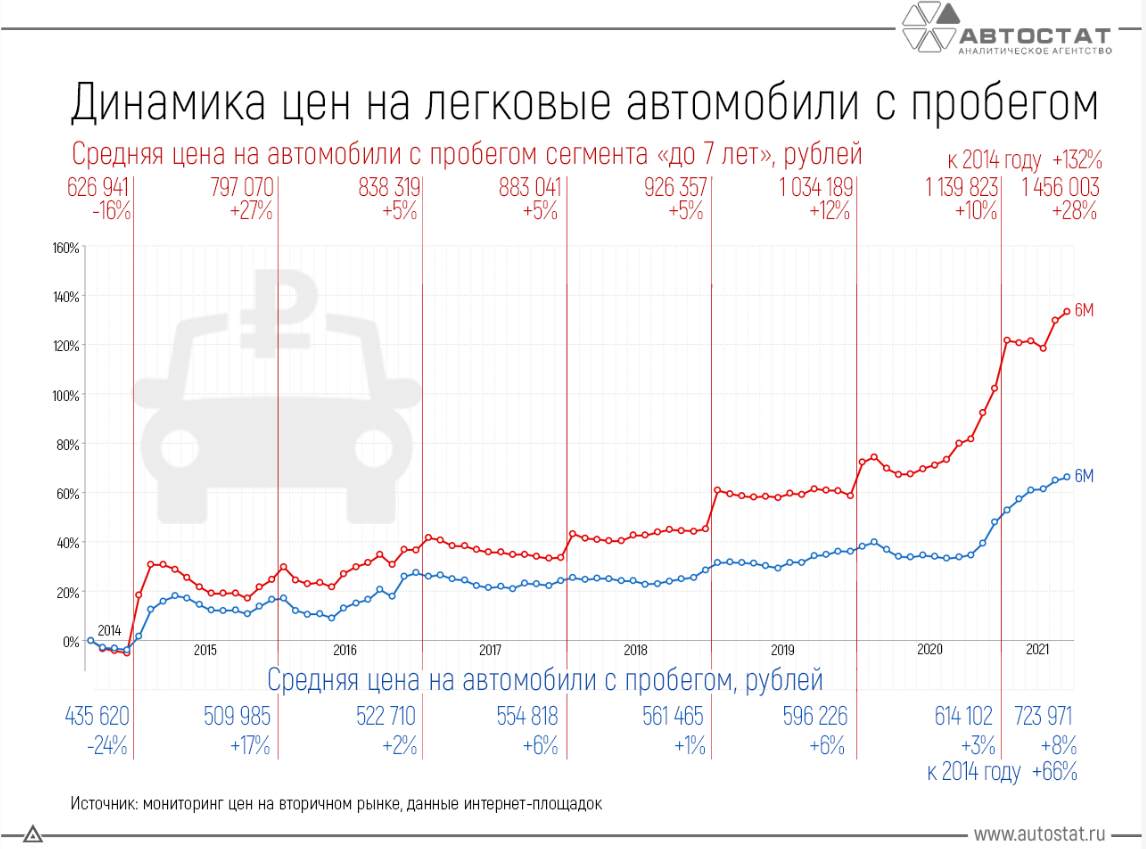

In [88]:
# Умножим целевой признак на 0.763, согласно описанию статьи выше. Т.е. занижение цен в тренировочном датасете на 23,7%.
data['price'] = data['price']*0.763

# 7. Подготовка данных для обучения <a name='paragraph6'></a>

In [89]:
# Формируем данные для обучения
X = data.query('sample == 1').drop(['sample','price'], axis=1)
y = data.query('sample == 1').price

# Отдельно выделим тестовые данные для итоговых предсказаний 
X_sub = data.query('sample == 0').drop(['sample','price'], axis=1)

In [90]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 8. Модель 1. "Наивная" модель <a name='paragraph7'></a>
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [91]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [92]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 75.99%

Со всеми новыми фичами кроме car-year-old Точность модели по метрике MAPE: 83.69%

Со всеми новыми фичами Точность модели по метрике MAPE: 84.53%

car-year-old Точность наивной модели по метрике MAPE: 84.53%

Точность наивной модели по метрике MAPE: 84.53%

Точность наивной модели по метрике MAPE: 88.44%

# 9. Модель 2. CatBoost <a name='paragraph8'></a>

У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [93]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_baseline.model')

In [94]:
# # оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Со всеми новыми фичами кроме car-year-old Точность модели по метрике MAPE: 7.35%

## CatBoost + log.target

In [95]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_2_baseline.model')

In [96]:
#predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))

In [97]:
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Со всеми новыми фичами кроме car-year-old Точность модели по метрике MAPE: 5.93%

## CatBoostRegressor + randomized_search

In [98]:
# model = CatBoostRegressor(random_state=RANDOM_SEED, 
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE'],
#                          silent=True)
# grid = {'iterations' : [5000, 10000, 20000],
#        'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}
# randomized_search_result = model.randomized_search(grid,
#                                                    X=X_train,
#                                                    y=np.log(y_train), 
#                                                    cv=5)

Error displaying widget

bestTest = 0.004910759733
bestIteration = 9999

0:	loss: 0.0049108	best: 0.0049108 (0)	total: 1m 34s	remaining: 14m 9s

bestTest = 0.003704830498
bestIteration = 19998

1:	loss: 0.0037048	best: 0.0037048 (1)	total: 4m 45s	remaining: 19m 2s

bestTest = 0.003564906556
bestIteration = 9999

2:	loss: 0.0035649	best: 0.0035649 (2)	total: 6m 54s	remaining: 16m 6s

bestTest = 0.00416053185
bestIteration = 9999

3:	loss: 0.0041605	best: 0.0035649 (2)	total: 9m	remaining: 13m 30s

bestTest = 0.003421611728
bestIteration = 19998

4:	loss: 0.0034216	best: 0.0034216 (4)	total: 13m 16s	remaining: 13m 16s

bestTest = 0.003641557874
bestIteration = 4999

5:	loss: 0.0036416	best: 0.0034216 (4)	total: 16m 27s	remaining: 10m 58s

bestTest = 0.003479211428
bestIteration = 9998

6:	loss: 0.0034792	best: 0.0034216 (4)	total: 22m 48s	remaining: 9m 46s

bestTest = 0.003608385209
bestIteration = 9999

7:	loss: 0.0036084	best: 0.0034216 (4)	total: 29m 7s	remaining: 7m 16s

bestTest = 0.003581523467
bestIteration = 9962

8:	loss: 0.0035815	best: 0.0034216 (4)	total: 35m 28s	remaining: 3m 56s

bestTest = 0.003409281543
bestIteration = 19810

9:	loss: 0.0034093	best: 0.0034093 (9)	total: 48m 10s	remaining: 0us

In [99]:
#randomized_search_result['params']

Лучшая комбинация v2: {'depth': 10, 'l2_leaf_reg': 3, 'iterations': 20000, 'learning_rate': 0.03}

Лучшая комбинация v1: {'depth': 6, 'l2_leaf_reg': 3, 'iterations': 20000, 'learning_rate': 0.1}

In [100]:
#Обучим модель на самой лучшей комбинации
model = CatBoostRegressor(iterations = 20000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          learning_rate=0.03,
                          l2_leaf_reg=3,
                          depth=10,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [101]:
predict_test = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))

In [102]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 4.52%

Точность модели по метрике MAPE на ЛБ: 15.44046%

# 10. Модель 3. RandomForest <a name='paragraph9'></a>

## Fit

In [103]:
# # Обучим модель с помощью RandomForestRegressor
# rfr = RandomForestRegressor(max_features=int(np.sqrt(len(data.columns))), n_jobs=-1, verbose=1,random_state=RANDOM_SEED)
# rfr.fit(X_train, y_train)
# predict_rfr = rfr.predict(X_test)

# print(f"Точность модели по метрике MAPE RandomForestRegressor: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE RandomForestRegressor: 5.23%

## RandomForestRegressor + log.target

In [104]:
# rfr = RandomForestRegressor(max_features=int(np.sqrt(len(data.columns))), n_jobs=-1, verbose=1,random_state=RANDOM_SEED)
# rfr.fit(X_train, np.log(y_train))
# predict_rfr = np.exp(rfr.predict(X_test))

# print(f"Точность модели по метрике MAPE RandomForestRegressor: {(mape(y_test, predict_rfr))*100:0.2f}%")  

Точность модели по метрике MAPE RandomForestRegressor: 4.48%

## RandomForestRegressor + log.target + cv

In [105]:
# # Зададим ограничения для параметра регуляризации
# n_estimators = [200, 300]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(1, 10, num = 5)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# # Создадим гиперпараметры
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Создаем сетку поиска
# # указываем модель (в нашем случае RandomForestRegressor), гиперпараметры
# rfr = RandomForestRegressor(random_state=42)
# rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=100, 
#                                cv=5, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)

# # Обучаем модель
# rfr_random.fit(X_train, np.log(y_train))
# predict_rfr = np.exp(rfr_random.predict(X_test))

# print(f"Точность модели по метрике MAPE RandomForestRegressor: {(mape(y_test, predict_rfr))*100:0.2f}%") 

Точность модели по метрике MAPE RandomForestRegressor: 4.48%

In [106]:
#rfr_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [120]:
# rfr = RandomForestRegressor(max_features=int(np.sqrt(len(data.columns))), 
#                             n_estimators=200, 
#                             min_samples_split=2, 
#                             min_samples_leaf=1,
#                             max_depth=None, 
#                             bootstrap=False,
#                             n_jobs=-1, 
#                             verbose=1,
#                             random_state=RANDOM_SEED)
# rfr.fit(X_train, np.log(y_train))
# predict_rfr = np.exp(rfr.predict(X_test))

# print(f"Точность модели по метрике MAPE RandomForestRegressor: {(mape(y_test, predict_rfr))*100:0.2f}%") 

Точность модели по метрике MAPE RandomForestRegressor: 4.44%

Точность модели по метрике MAPE на ЛБ: 16.16644%

# 11. Модель 4. ExtraTreesRegressor <a name='paragraph10'></a>

## Fit

In [121]:
# # Обучим модель с помощью ExtraTreesRegressor
# etr = ExtraTreesRegressor(max_features=int(np.sqrt(len(data.columns))), n_jobs=-1, verbose=1,random_state=RANDOM_SEED)
# etr.fit(X_train, y_train)
# predict_etr = etr.predict(X_test)

# print(f"Точность модели по метрике MAPE ExtraTreesRegressor: {(mape(y_test, predict_etr))*100:0.2f}%")

Точность модели по метрике MAPE ExtraTreesRegressor: 5.21%

## ExtraTreesRegressor + log.target

In [122]:
# etr = ExtraTreesRegressor(max_features=int(np.sqrt(len(data.columns))), n_jobs=-1, verbose=1,random_state=RANDOM_SEED)
# etr.fit(X_train, np.log(y_train))
# predict_etr = np.exp(etr.predict(X_test))

# print(f"Точность модели по метрике MAPE ExtraTreesRegressor: {(mape(y_test, predict_etr))*100:0.2f}%")  

Точность модели по метрике MAPE ExtraTreesRegressor: 4.67%

## ExtraTreesRegressor + log.target + cv

In [110]:
# # Зададим ограничения для параметра регуляризации
# n_estimators = [200,300]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(1, 10, num = 5)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# # Создадим гиперпараметры
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Создаем сетку поиска
# # указываем модель (в нашем случае ExtraTreesRegressor), гиперпараметры
# etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
# etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid, n_iter=100, 
#                                cv=5, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)

# # Обучаем модель
# etr_random.fit(X_train, np.log(y_train))
# predict_etr = np.exp(etr_random.predict(X_test))

# print(f"Точность модели по метрике MAPE ExtraTreesRegressor: {(mape(y_test, predict_etr))*100:0.2f}%") 

Точность модели по метрике MAPE ExtraTreesRegressor: 4.49%

In [111]:
# etr_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [123]:
# etr = ExtraTreesRegressor(n_estimators = 300, 
#                           max_features='auto',
#                           min_samples_split=5, 
#                           min_samples_leaf=1, 
#                           n_jobs=-1,max_depth=None, 
#                           verbose=1, 
#                           random_state=RANDOM_SEED, 
#                           bootstrap=False)
# etr.fit(X_train, np.log(y_train))
# predict_etr = np.exp(etr.predict(X_test))

# print(f"Точность модели по метрике MAPE ExtraTreesRegressor: {(mape(y_test, predict_etr))*100:0.2f}%")  

Точность модели по метрике MAPE ExtraTreesRegressor: 4.49%

Точность модели по метрике MAPE на ЛБ: 16.14909%

# 12. Модель 5. XGBRegressor <a name='paragraph11'></a>

In [113]:
# # Создадим гиперпараметры
# parameters = {'nthread':[4], 
#               'objective':['reg:linear'],
#               'learning_rate': [0.03, 0.05, 0.07],
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# # Создаем сетку поиска
# # указываем модель (в нашем случае XGBRegressor), гиперпараметры
# xgb = XGBRegressor(random_state=RANDOM_SEED)
# xgb_grid = GridSearchCV(xgb,
#                         parameters,
#                         cv = 5,
#                         n_jobs = -1,
#                         verbose=True)

# # Обучаем модель
# xgb_grid.fit(X_train, np.log(y_train))
# predict_xgb = np.exp(xgb_grid.predict(X_test))

# print(f"Точность модели по метрике MAPE XGBRegressor: {(mape(y_test, predict_xgb))*100:0.2f}%") 

Точность модели по метрике MAPE XGBRegressor: 6.13%

In [114]:
# xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [124]:
# xgb = XGBRegressor(colsample_bytree=0.7, 
#                    learning_rate=0.07, 
#                    max_depth=7, 
#                    min_child_weight=4, 
#                    n_estimators=500, 
#                    nthread=4, 
#                    objective='reg:linear', 
#                    silent=1, 
#                    subsample=0.7, 
#                    random_state=RANDOM_SEED)

# xgb.fit(X_train, np.log(y_train))
# predict_xgb = np.exp(xgb.predict(X_test))

# print(f"Точность модели по метрике MAPE XGBRegressor: {(mape(y_test, predict_xgb))*100:0.2f}%") 

Точность модели по метрике MAPE XGBRegressor: 6.13%

Точность модели по метрике MAPE на ЛБ: 15.92726%

# 13. Stacking <a name='paragraph12'></a>

In [116]:
# from sklearn.ensemble import StackingRegressor

# estimators = [('rfr', RandomForestRegressor(max_features=int(np.sqrt(len(data.columns))), 
#                                             n_estimators=200, 
#                                             min_samples_split=2, 
#                                             min_samples_leaf=1,
#                                             max_depth=None, 
#                                             bootstrap=False,
#                                             n_jobs=-1, 
#                                             verbose=1,
#                                             random_state=RANDOM_SEED)),
#               ('etr', ExtraTreesRegressor(n_estimators = 300, 
#                                           max_features='auto',
#                                           min_samples_split=5, 
#                                           min_samples_leaf=1, 
#                                           n_jobs=-1,max_depth=None, 
#                                           verbose=1, 
#                                           random_state=RANDOM_SEED, 
#                                           bootstrap=False)),
#               ('xgb', XGBRegressor(colsample_bytree=0.7, 
#                                    learning_rate=0.07, 
#                                    max_depth=7, 
#                                    min_child_weight=4, 
#                                    n_estimators=500, 
#                                    nthread=4, 
#                                    objective='reg:linear', 
#                                    silent=1, 
#                                    subsample=0.7, 
#                                    random_state=RANDOM_SEED))]

# reg = StackingRegressor(estimators=estimators,
#                         final_estimator=CatBoostRegressor(iterations = 20000,
#                                           random_seed = RANDOM_SEED,
#                                           eval_metric='MAPE',
#                                           custom_metric=['R2', 'MAE'],
#                                           silent=True,
#                                           learning_rate=0.03,
#                                           l2_leaf_reg=3,
#                                           depth=10))

# reg.fit(X_train, np.log(y_train))

   

In [117]:
# predict_test = np.exp(reg.predict(X_test))
        
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%") 

Точность модели по метрике MAPE: 5.29%

Точность модели по метрике MAPE на ЛБ: 18.2522%

# Submission <a name='paragraph13'></a>

In [127]:
predict_submission = np.exp(model.predict(X_sub))

In [128]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)

## Итог
* Лучший результат на ЛБ - 15.37946. Лучшая модель CatBoostRegressor + randomized_search 
* Возможно невысокий результат не очень хороший из-за большой инфляции на рынке подержанных авто, несмотря на понижающий коэффициент 0.763.

## Что не успел
* Много времени ушло на парсинг данных
* Времени не хватило на более объемный feature engeenearing
* Попробовать другие алгоритмы и библиотеки ML
* Попробовать поподобрать параметры у моделей
* Попробовать другие алгоритмы и библиотеки ML
* Ансамбль моделей попробовал применить, но результата это не дало положительного.
* Поработать в команде

### Детали реализации

1. Разработан парсер данных с сайта auto.ru
2. Парсинг данных по брендам : 'SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI','MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'. В итоге была собрана информация по 113074 авто. Сформированы следующие файлы формата .csv:
    * auto_ru_data_skoda.csv
    * auto_ru_data_audi.csv
    * auto_ru_data_honda.csv
    * auto_ru_data_volvo.csv
    * auto_ru_data_bmw.csv
    * auto_ru_data_nissan.csv
    * auto_ru_data_infiniti.csv
    * auto_ru_data_mercedes.csv
    * auto_ru_data_toyota.csv
    * auto_ru_data_volkswagen.csv
    * auto_ru_data_mitsubishi.csv 
    * auto_ru_data_rare.csv
3. Произведена предобработка данных
4. Сделан Разведочный анализ данных (EDA)
5. Созданы новые признаки (Feature engineering)
6. Сделано преобразование данных (Lable encoding)
7. Определены основные признаки для обучения
8. Создана модель 1. "Наивная" модель
9. Создана модель 2. CatBoost
10. Создана модель 3. RandomForest
11. Создана модель 4. ExtraTreesRegressor
12. Создана модель 5. XGBRegressor
13. Сделан Stacking